In [2]:
from Bio import Entrez
from Bio import SeqIO
from Bio.SeqIO import read
import os 
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px
import pyorthoani
import itertools
from sklearn.linear_model import LinearRegression
from watermark import watermark
import timeit
import array

In [16]:
dependecies=watermark(iversions=True,globals_=globals(),python=True,conda=True)
dependecies=dependecies.split('\n')
for i,dep in enumerate(dependecies):
    dependecies[i]=dep.replace(' ','').replace(':','==')
with open('requirements.txt','w') as f:
    for dep in dependecies:
        f.write(dep+'\n')    

In [17]:
outdir= "NCBI_downloads"
os.makedirs(outdir,exist_ok=True)

Entrez.email = 'lorenzo.barletta@studenti.unipd.it'

Downloadin sequences from NCBI 

In [18]:
seq_record_str=[]
seq_record= []
# Define a list of genome IDs
genome_ids = ['U00096.3', 'BA000007.3', 'CP002967.1']

# Create the directory if it doesn't exist
if not os.path.exists(outdir):
    os.makedirs(outdir)
# Download genome sequences for IDs whose files are not present in the directory
for genome_id in genome_ids:
    filename = os.path.join(outdir, f"{genome_id}.fasta")  # Specify the output directory in the filename

    if not os.path.isfile(filename):
        try:
            net_handle = Entrez.efetch(db='nucleotide', id=genome_id, rettype='fasta', retmode='text')
            with open(filename, "w") as out_handle: 
                out_handle.write(net_handle.read())
            net_handle.close()
        except Exception as e:
            print(f"Error downloading genome {genome_id}: {e}")

for genome_id in genome_ids:
    file = f"{genome_id}.fasta"
    for record in SeqIO.parse(os.path.join(outdir, file), 'fasta'): 
        seq_record.append((record.id,record.seq))
        seq_record_str.append(str(record.seq))


SNP

In [3]:
mut_upto1 = np.linspace(0.1,1,10)
mut_upto10 = np.linspace(2,10,9)
mut_array= np.concatenate((mut_upto1,mut_upto10))

In [4]:
basiupper=["A","T","C","G"]
weights=[0.25,0.25,0.25,0.25]

In [5]:
def make_synth_seq(N,seq_length):
    list_ofseq=[]
  
    for i in range(N):
       
        sequence="".join(random.choice(basiupper)for i in range(seq_length))
        #print(sequence, len(sequence))
        list_ofseq.append(sequence)
   
    return list_ofseq

Funzione SNP_1_opt prende in input la lista di sequenze e crea tante sequenze mutate quanti sono gli elementi presenti nell'array dei mutation rate

SNP optimized 

In [ ]:
def SNP_1_opt(newlist,psrandom):
    newlist_copy = newlist.copy()
    
    mut_array_new = [next([mut_array[k:]] for k, val in enumerate(mut_array) if (val / 100) * len(s) >= 1) for s in newlist_copy]
    #choices = [random.choice(mut_array_new[0]) for _ in newlist_copy]
    list_ofseq = []
    for counter,(mut, s) in enumerate(zip(mut_array_new, newlist_copy)):
        list_ofseq.extend([[s,choice,counter+1,int((choice*len(s))/100)] for choice in mut[0]])

    changes = []
    index_dict = {}
    for sequence,mut,ori,size in list_ofseq:
            if (ori,mut) not in index_dict:
                index_dict[(ori,mut)] = {'indices': [], 'mutations_No': size}
    if psrandom == True:
        for sequence,mut,ori,size in list_ofseq:
            # Select 3 random splits of the sequence indexes to mutate 
            index_range = np.arange(len(sequence))
            split_index = np.array_split(index_range, 10) # Split the indexes into 10 parts
            selected_index = random.sample(split_index,3) # Select 3 random splits
            joined_selected_index = np.concatenate(selected_index)
            
            index = np.random.choice(joined_selected_index,size=size,replace=False)
            array_seq = bytearray(sequence.encode())
            for i in index:
                replaced_base = array_seq[i]
                new_base = random.choice(basiupper)
                while chr(replaced_base) == new_base:
                    new_base = random.choice(basiupper)
                index_dict[(ori,mut)]['indices'].append({'index':i, 'base_before': chr(replaced_base), 'base_after': new_base})
                array_seq[i]= ord(new_base)
            changes.append([array_seq.decode(),ori,mut,size])
    else:
        for sequence,mut,ori,size in list_ofseq:
    
            array_seq = bytearray(sequence.encode())
            index = np.random.choice(len(sequence),size=size,replace=False)
            for i in index:
                replaced_base = array_seq[i]
                new_base = random.choice(basiupper)
                while chr(replaced_base) == new_base:
                    new_base = random.choice(basiupper)
                index_dict[(ori,mut)]['indices'].append({'index':i, 'base_before': chr(replaced_base), 'base_after': new_base})
                array_seq[i]= ord(new_base)
            changes.append([array_seq.decode(),ori,mut,size])

    return changes, index_dict

In [23]:
def kde(index_dataframe):
    seq_arrays = []
    # Get unique Origin_seq values
    unique_origins = index_dataframe['Origin_seq'].unique()

    # Create a subplot for each unique Origin_seq
    fig, axs = plt.subplots(len(unique_origins), figsize=(10, 5*len(unique_origins)))

    for i, origin in enumerate(unique_origins):
        # Create seq_arrays for the current origin
        seq_arrays = []
        for seq_no in index_dataframe[index_dataframe['Origin_seq'] == origin]['Seq. No'].unique():
            seq_array = index_dataframe[(index_dataframe['Seq. No'] == seq_no) & (index_dataframe['Origin_seq'] == origin)]['Index'].values
            seq_arrays.append(seq_array)

        # Generate colors for each unique seq_no
        colors = plt.cm.tab20(np.linspace(0, 1, len(seq_arrays)))

        for j, (seq_no, seq_array) in enumerate(zip(index_dataframe[index_dataframe['Origin_seq'] == origin]['Seq. No'].unique(), seq_arrays)):
            mut_rate = index_dataframe[(index_dataframe["Seq. No"] == seq_no) & (index_dataframe['Origin_seq'] == origin)]["Mut_rate"].values[0]
            mut_rate = round(mut_rate, 2)  # Round to the second decimal place
            color = colors[j]  # Get the color for the current seq_no
            sns.kdeplot(seq_array, label=f'{seq_no}[{mut_rate}]', ax=axs[i], color=color)
            axs[i].set_title(f'Origin_seq: {origin}')
            axs[i].legend(prop={'size': 8})

    # Show the plots
    plt.tight_layout()
    plt.show()

In [7]:
def plotly_kde_dropdown(index_dataframe):
    # Get unique Origin_seq values
    unique_origins = index_dataframe['Origin_seq'].unique()
    
    # Create an empty figure
    fig = go.Figure()
    
    # Prepare dropdown menu options
    dropdown_buttons = []
    
    # Dictionary to map origin to trace indices
    origin_traces = {origin: [] for origin in unique_origins}
    
    # Process all origins and add traces with visibility set
    for i, origin in enumerate(unique_origins):
        # Get unique Seq. No values for this origin
        seq_nos = index_dataframe[index_dataframe['Origin_seq'] == origin]['Seq. No'].unique()
        colors = [f'rgb{tuple(int(x*255) for x in plt.cm.tab20(j/len(seq_nos))[:3])}' for j in range(len(seq_nos))]

        visible = (i == 0)  # Only first origin visible by default
        
        for j, seq_no in enumerate(seq_nos):
            # Extract data for this sequence number and origin
            seq_data = index_dataframe[(index_dataframe['Seq. No'] == seq_no) & 
                                      (index_dataframe['Origin_seq'] == origin)]
            
            seq_array = seq_data['Index'].values
            mut_rate = round(seq_data["Mut_rate"].values[0], 2)
            
            # Create KDE plot
            kde_fig = ff.create_distplot([seq_array], [f'{seq_no}[{mut_rate}]'], 
                                        colors=[colors[j]], show_hist=False, show_rug=False)
            
            # Add the trace to the main figure with visibility setting
            for trace in kde_fig['data']:
                trace.visible = visible
                # Tag the trace with the origin information
                trace.name = f"{origin}_{trace.name}"
                current_index = len(fig.data)
                origin_traces[origin].append(current_index)
                fig.add_trace(trace)
    
    # Create buttons for each origin
    for i, origin in enumerate(unique_origins):
        # Create visibility array - False for all traces by default
        visibility = [False] * len(fig.data)
        
        # Set visible=True ONLY for traces belonging to this origin
        for idx in origin_traces[origin]:
            visibility[idx] = True
            
        # Create button for dropdown menu
        button = dict(
            method="update",
            label=f"Origin_seq: {origin}",
            args=[{"visible": visibility},
                  {"title": f"KDE Distribution - Origin_seq: {origin}"}]
        )
        
        dropdown_buttons.append(button)
    
    # Update layout with dropdown menu
    fig.update_layout(
        updatemenus=[
            dict(
                active=0,
                buttons=dropdown_buttons,
                direction="down",
                pad={"r": 10, "t": 10},
                showactive=True,
                xanchor="left",
                y=1.08,
                yanchor="top"
            ),
        ],
        title="KDE Distribution",
        height=800,
        width=1000,
        xaxis_title="Index",
        yaxis_title="Density",
        showlegend=True,
        template='simple_white',
        legend=dict(font=dict(size=8))
    )
    
    return fig

In [8]:
def duplicated_index(dataframe):
    table = dataframe.copy()
    index_dict = {}
    unique_seq_nos = table['Seq. No'].unique()
    for seq_no in unique_seq_nos: 
        seq_no_duplicates = table[table['Seq. No'] == seq_no]
        if seq_no_duplicates.duplicated(['Index'],keep=False).any():
            index_dict[seq_no]= seq_no_duplicates[seq_no_duplicates.duplicated(keep='last')]['Index']
        #print(any(seq_no_duplicates.duplicated(['Index'], keep=False)))
    if len(index_dict) == 0:
        print("No duplicated indexes found.")
    else:
        return index_dict

SNP con sequenze sintetiche 

In [26]:
test_seq = ['MADDALENA_GATTO_MADDALENA_GATTO_MADDALENA_GATTO_MADDALENA_GATTO', 'GIULIO_BRUZZOLO_GIULIO_BRUZZOLO_GIULIO_BRUZZOLO_GIULIO_BRUZZOLO', 'LORENZO_BARLETTA_LORENZO_BARLETTA_LORENZO_BARLETTA_LORENZO_BARLETTA']


In [9]:
N=int(input('how many sequences: '))
seq_length = int(input("Input the desired lenght for random sequence: "))
newlist_ofseq = make_synth_seq(N,seq_length)

get_seq_out = []
for s in newlist_ofseq:
    get_seq_out.append(s)

In [14]:
seq2,data2= SNP_1_opt(newlist_ofseq,False)

In [15]:
snpdata = []
for count,((ori,mut), value) in enumerate(data2.items()):
    for i in value['indices']:
        row = {'Seq. No':count,'Origin_seq':ori,'Mut_rate':mut,'Index':i['index'],'Base_Before':i['base_before'],'Base_After':i['base_after']}
        snpdata.append(row)
snp_dataframe = pd.DataFrame(snpdata)
snp_dataframe

Seq. No  Origin_seq  Mut_rate   Index Base_Before Base_After
0             0           1       0.1  100970           T          C
1             0           1       0.1  414228           T          G
2             0           1       0.1  289837           T          A
3             0           1       0.1   16097           G          A
4             0           1       0.1  489491           G          T
...         ...         ...       ...     ...         ...        ...
892495       56           3      10.0  336740           T          G
892496       56           3      10.0  288924           A          C
892497       56           3      10.0  235882           T          A
892498       56           3      10.0  192955           G          T
892499       56           3      10.0  414021           A          T

[892500 rows x 6 columns]

In [30]:
new_dataframe3 = snp_dataframe.groupby(['Seq. No', 'Base_After'])['Base_After'].count().unstack(fill_value=0)
new_dataframe3 = new_dataframe3.reset_index()
new_dataframe3 = new_dataframe3.melt(id_vars='Seq. No', value_vars=['A', 'C', 'G', 'T'], var_name='Base', value_name='Count') 
new_dataframe3 = new_dataframe3.sort_values('Seq. No')

In [16]:
index_dataframe3 = snp_dataframe.groupby(['Seq. No', 'Index','Base_After','Mut_rate','Origin_seq'])['Index'].apply(list).reset_index(name='Indexes')
index_dataframe3 = index_dataframe3.explode('Indexes')
index_dataframe3['Indexes'] = index_dataframe3['Indexes'].astype(int)
index_dataframe3 = index_dataframe3.sort_values(['Seq. No', 'Indexes'])
index_dataframe3 = index_dataframe3.reset_index(drop=True)
index_dataframe3 = index_dataframe3.drop('Indexes', axis=1)

In [32]:
duplicated_index(index_dataframe3)

No duplicated indexes found.


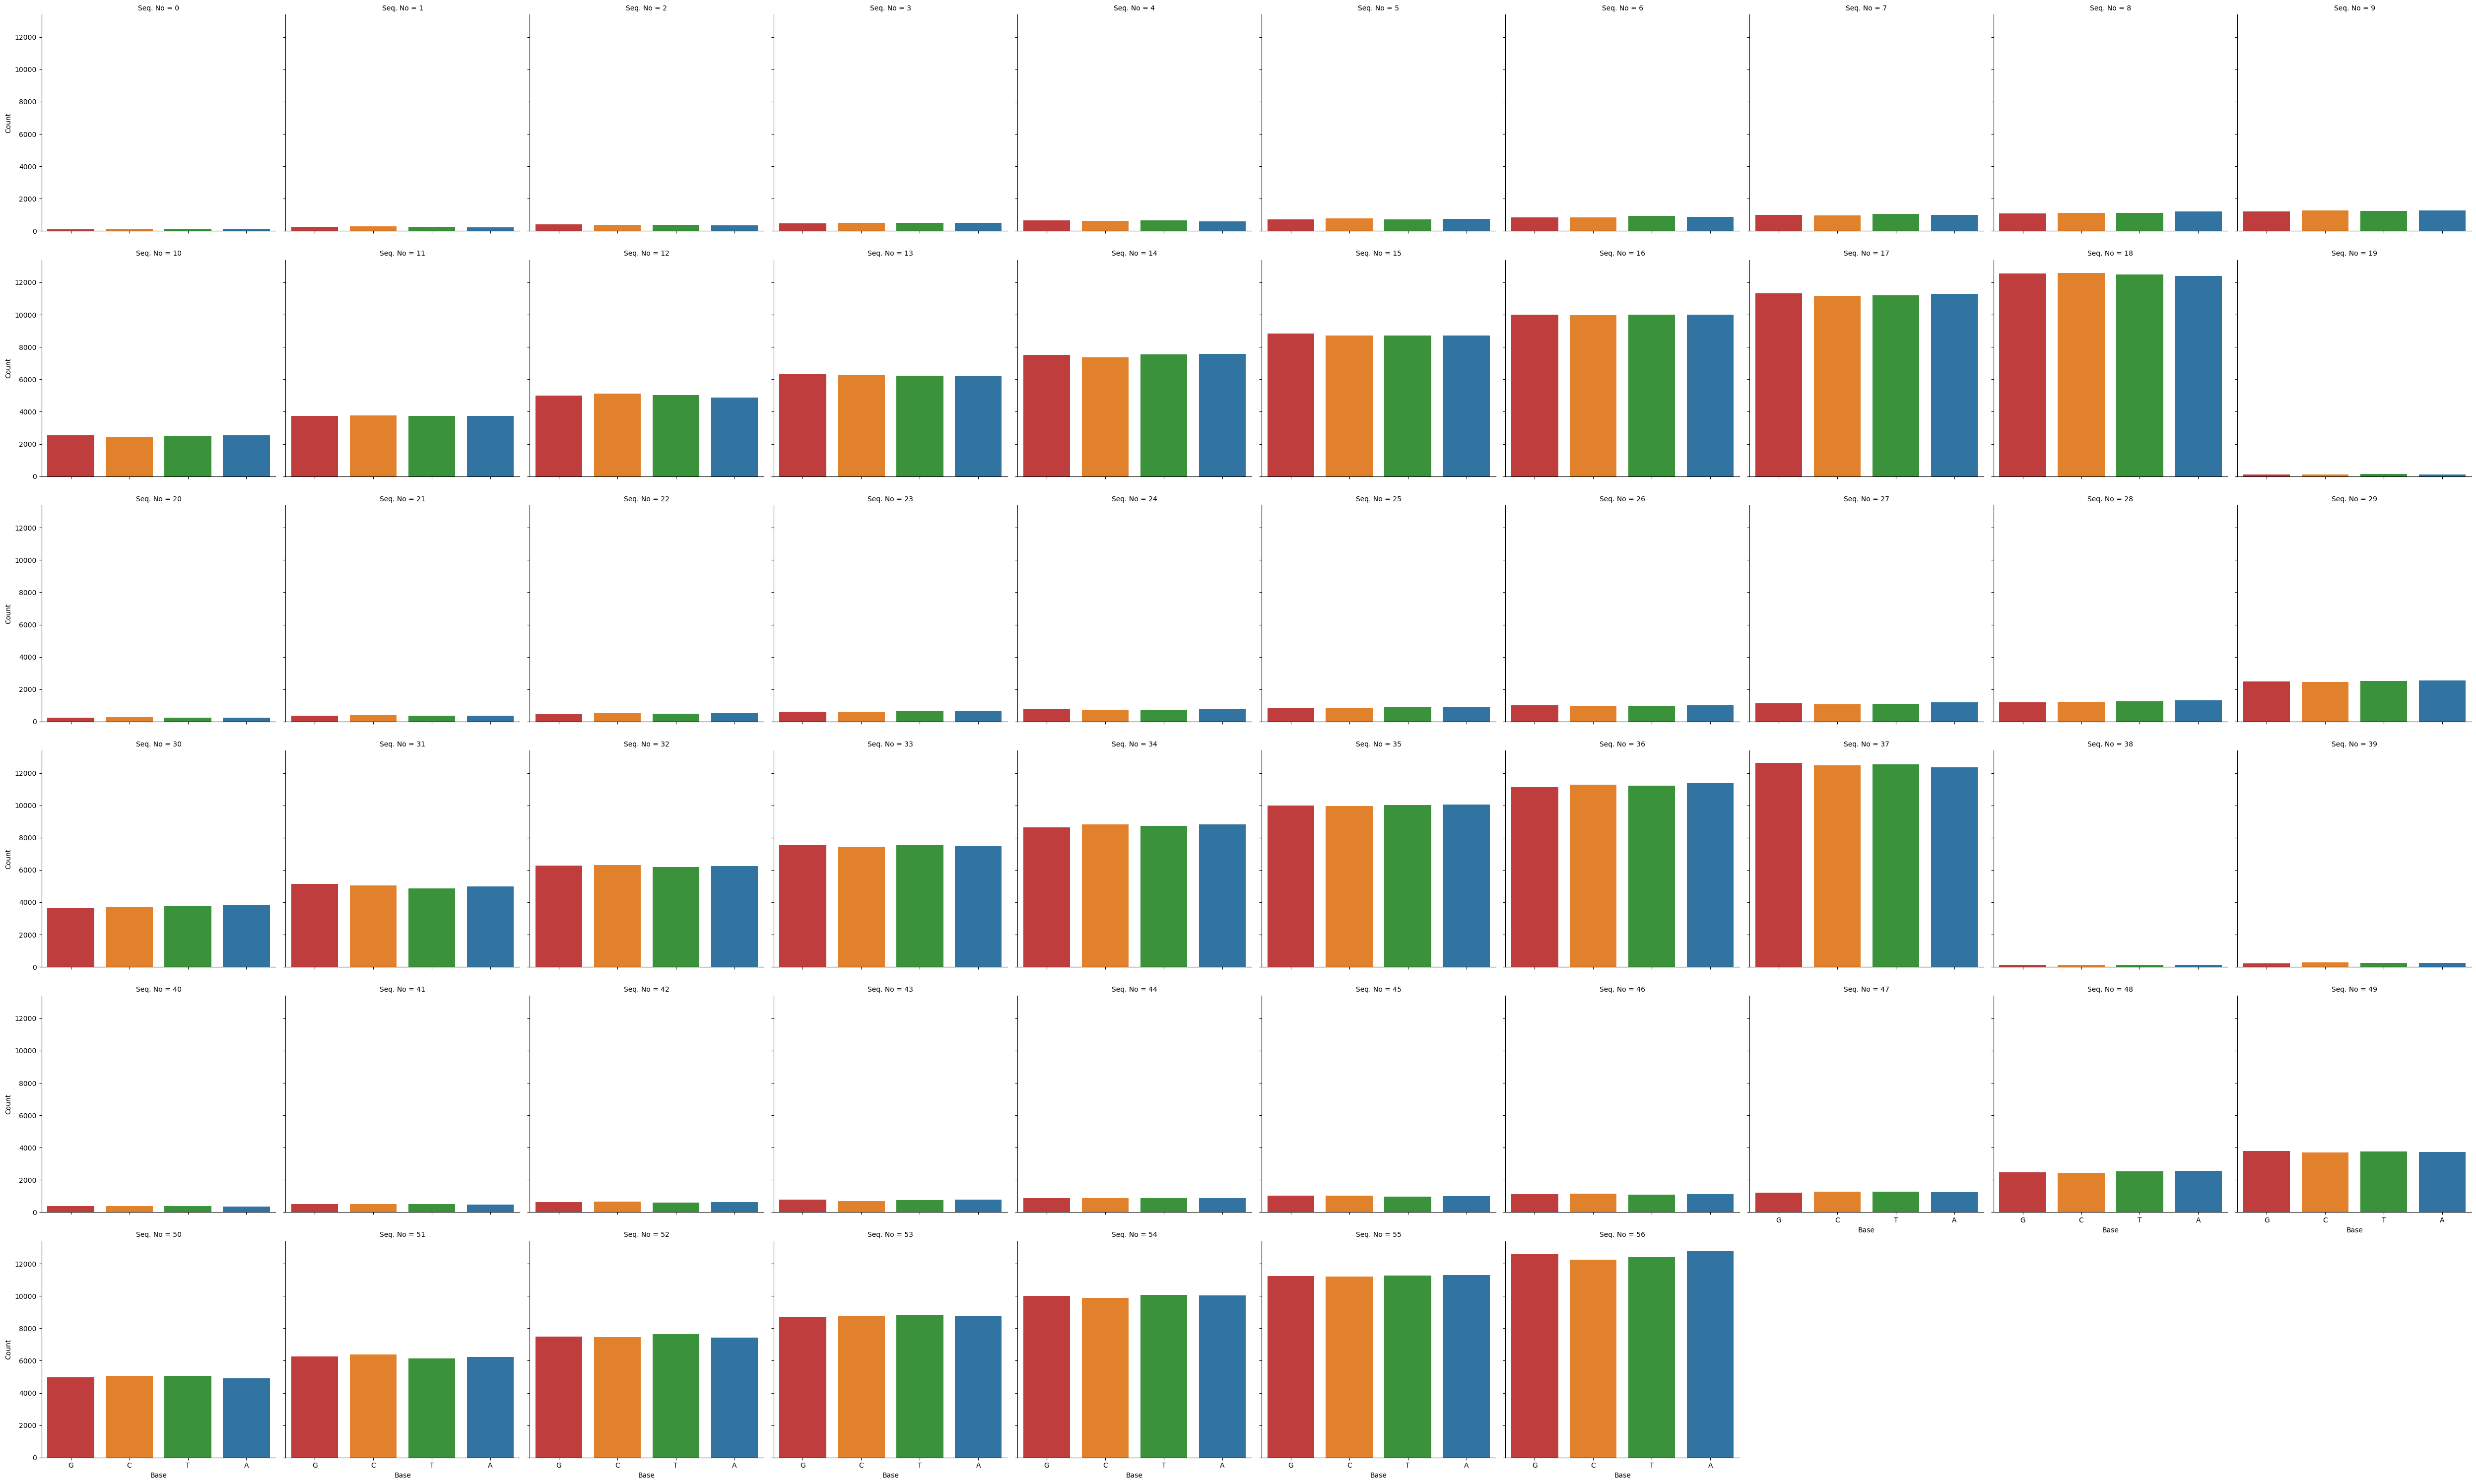

In [64]:
grid = sns.FacetGrid(new_dataframe3, col='Seq. No', hue='Base', height=5, col_wrap=10)
grid.map(sns.barplot, 'Base', 'Count',order=['G', 'C', 'T', 'A'])


Distribuzione degli indici dove sono avvenute le mutazioni

In [17]:
plotly_kde_dropdown(index_dataframe3)

Dizionario con sequenza originale e relative modifiche 

In [26]:
def makedict (og_list,mut_list):
    dictionary = {}
    for i, seq in enumerate(og_list):
        dictionary[f'Origin{i+1}']= seq 
        dictionary[f'Mutations{i+1}'] =[s[0] for s in mut_list if s[1] == i+1]    
    return dictionary

In [22]:
dict1=makedict(newlist_ofseq,seq2)

Funzione per scrivere il dizionario come file fasta 

In [25]:
def makefasta (dictionary, outdir):
    outdir2 = os.path.join(outdir, "genome_paths")

    if not os.path.exists(outdir2):
        os.makedirs(outdir2)
    if not os.path.exists(outdir):
        os.makedirs(outdir)
    # Open the files in "w" mode to clear them
    with open(os.path.join(outdir2,"origins.txt"),"w") as _: pass
    with open(os.path.join(outdir2,"mutations.txt"), "w") as _: pass 

    seen_mutations = set()

    for key, value in dictionary.items():
        if key.startswith('Origin'):
            with open(os.path.join(outdir,f"{key}.fasta"), "w") as out_handle:
                out_handle.write(f">{key}\n")
                out_handle.write(f"{value}\n")
                with open(os.path.join(outdir2,"origins.txt"), "a") as text_file: 
                    text_file.write(os.path.abspath(os.path.join(outdir,f"{key}.fasta\n")))               
        else:    
            if key not in seen_mutations:
                with open(os.path.join(outdir2, f"{key}.txt"), "w") as _: pass
                seen_mutations.add(key)

            for counter in range(len(value)): 
                with open(os.path.join(outdir,f"{key}.{counter}.fasta"), "w") as out_handle:
                    out_handle.write(f">{key}.{counter}\n")
                    out_handle.write(f"{value[counter]}\n")
                    with open(os.path.join(outdir2,f"{key}.txt"), "a") as text_file:
                        text_file.write(os.path.abspath(os.path.join(outdir,f"{key}.{counter}.fasta\n"))) 

Creazione della cartella con i file in formato fasta e i file testo con le liste dei file fasta per fastANI e skani  

In [24]:
dir = input("Input the desired directory name for the fasta files of the SNP mutations:")
makefasta(dict1, dir)

SNP pseudo randomica apporta mutazioni solo in alcune aree selezionate randomicamente della sequenza 

In [29]:
pseudoseq,pseudodata =SNP_1_opt(newlist_ofseq,True)

In [30]:
snpdata = []
for count,((ori,mut), value) in enumerate(pseudodata.items()):
    for i in value['indices']:
        row = {'Seq. No':count,'Origin_seq':ori,'Mut_rate':mut,'Index':i['index'],'Base_Before':i['base_before'],'Base_After':i['base_after']}
        snpdata.append(row)
pseudosnp_dataframe = pd.DataFrame(snpdata)

In [31]:
pseudosnp_dataframe

Seq. No  Origin_seq  Mut_rate   Index Base_Before Base_After
0             0           1       0.1  270732           G          A
1             0           1       0.1  320517           C          G
2             0           1       0.1  339800           G          A
3             0           1       0.1  346805           T          A
4             0           1       0.1   14132           G          T
...         ...         ...       ...     ...         ...        ...
892495       56           3      10.0  239287           T          A
892496       56           3      10.0   39346           A          C
892497       56           3      10.0  261326           A          C
892498       56           3      10.0  272934           G          A
892499       56           3      10.0  251658           G          A

[892500 rows x 6 columns]

In [32]:
index_dataframe4 = pseudosnp_dataframe.groupby(['Seq. No', 'Index','Base_After','Mut_rate','Origin_seq'])['Index'].apply(list).reset_index(name='Indexes')
index_dataframe4 = index_dataframe4.explode('Indexes')
index_dataframe4['Indexes'] = index_dataframe4['Indexes'].astype(int)
index_dataframe4 = index_dataframe4.sort_values(['Seq. No', 'Indexes'])
index_dataframe4 = index_dataframe4.reset_index(drop=True)
index_dataframe4 = index_dataframe4.drop('Indexes', axis=1)

Dataframe delle SNP pseudorandomiche 

In [33]:
plotly_kde_dropdown(index_dataframe4)

In [29]:
dict2= makedict(newlist_ofseq,pseudoseq)

-- fasta file delle SNP pseudorandom 

INDELS

In [52]:
size=50

totalop=random.choices(['IN','DEL'],k=size)
INSERTIONS=totalop.count('IN')
DELETIONS=totalop.count('DEL')
print(f"Total IN: {INSERTIONS/size*100}%, Total DEL: {DELETIONS/size*100}% ")


Total IN: 56.00000000000001%, Total DEL: 44.0% 


Insertions

In [117]:
def IN(insertion,changes,psin,ind): 
    insertion_lst_copy =  []

  
    for i in insertion:
        insertion_lst_copy.append(list(i))

    for count,i in enumerate(insertion_lst_copy):
        num_chars = 1  # Generates a random number of characters to add
        
        if psin == True:

            index = np.random.choice(ind)
        else:
            index = random.randint(0, len(i))  # Generates a random index
        if index not  in changes[count]:
            changes[count].append(index)
            for _ in range(num_chars):
                new_char = random.choice(basiupper)  # Generating a random character
                i.insert(index, new_char)
            
    insertion_lst_copy = ["".join(i) for i in insertion_lst_copy]
        #print(tracker)
    return insertion_lst_copy,changes


Deletions

In [12]:
def DEL(deletion,changes,psdel,ind):
    deletion_lst_copy = []

     
    for i in deletion:
        deletion_lst_copy.append(list(i))
            
    for count,i in enumerate(deletion_lst_copy):
        if len(i) == 1:
            print("the sequence has 1 character, cannot delete")
            continue

        if psdel == True:
           
            index = np.random.choice(ind)
        else:
            index = random.randint(0, len(i) - 1)  # Generates a random index
    
        if index not in changes[count]:
            changes[count].append(index)

            if index == len(i) - 1: # If the index is the last index, remove characters before it
                remove_before = True
            elif index == 0:    # If the index is the first index, remove characters after it
                remove_before = False
            else:
                remove_before = random.choice([True, False])  # Randomly select whether to remove before or after the index

            if remove_before:
                num_chars = 1  # Number of characters to remove before the index
                removed_chars = i[index-num_chars:index]
                del i[index-num_chars:index]
                #print(f"Removed {num_chars} random characters before index {index}: {removed_chars}")
            else:
                num_chars = 1  # Number of characters to remove after the index
                removed_chars = i[index+1:(index+1+num_chars)]
                del i[index+1:(index+1+num_chars)]
                #print(f"Removed {num_chars} random characters after index {index}: {removed_chars}")

        #print(f'Updated list: {"".join(i)}')
    deletion_lst_copy = ["".join(i) for i in deletion_lst_copy] 
    return deletion_lst_copy,changes

In [58]:
def INDEL(indel,pseudo):
    lst_indel_copy = indel.copy() # Copying the list to avoid modifying the original list
    list_ofmutseq = []
    mut_rates = []
    
    if not lst_indel_copy:
        print("List is empty, cannot perform INDEL operations.")
        return

    mut_array_new = [next([mut_array[k:]] for k, val in enumerate(mut_array) if (val / 100) * len(s) >= 1) for s in lst_indel_copy]
    
    for counter,(mut, s) in enumerate(zip(mut_array_new, lst_indel_copy)):
        mut_rates.extend([[choice,s,counter+1] for choice in mut[0]])

    changes = {(ori,m): [] for m,_,ori in mut_rates}    

    for count,(m,s,ori) in enumerate(mut_rates):
        in_count = 0
        del_count = 0
        numindels=0


        target_mut = int((m* len(s))/100)
        totalop=random.choices(['IN','DEL'],k=target_mut)
        INSERTIONS=totalop.count('IN')
        DELETIONS=totalop.count('DEL')
        print(f"Total IN: {INSERTIONS/target_mut*100}%, Total DEL: {DELETIONS/target_mut*100}% for the original sequence {ori} and muttation rate {m}%")

        if pseudo== True:
            # Select 3 random splits of the sequence indexes to mutate 
            index_range = np.arange(len(s))
            split_index = np.array_split(index_range, 10) 
            selected_index = random.sample(split_index,3) 
            indices = np.concatenate(selected_index)
        else:
            indices = []

        while numindels < target_mut:
            indlist = [[]]
            choice = random.choice([IN, DEL])
            if pseudo == True:
                results,indlist= choice([s],indlist,pseudo,indices)
                s=results[0]
            else:
                results,indlist= choice([s],indlist,pseudo,indices)
                s=results[0]
            
            if choice is IN:
                in_count += 1
                changes[(ori,m)].extend(indlist)
            elif choice is DEL:
                del_count += 1
                changes[(ori,m)].extend(indlist)  
            numindels = in_count + del_count

        for res in results:
            list_ofmutseq.append([res,ori,m])
        #lst_indel_copy = ["".join(i) for i in lst_indel_copy]
        
    return list_ofmutseq,changes



In [125]:
def IN_OPT(completelist,pseudo,changelist,psindexes):

    newlist = []
    if pseudo== True:
        for sequence,ori,mut,insertions,_ in completelist:

            seq_array = bytearray(sequence.encode())

            for i in psindexes[(ori,mut)]:
                seq_array.insert(i, ord(random.choice(basiupper)))
                changelist[(ori,mut)].append(i)
            newlist.append([seq_array.decode(),ori,mut,insertions,_])
    else:

        for sequence,ori,mut,insertions,_ in completelist:
            seq_array = bytearray(sequence.encode())
            index = np.random.randint(0, len(seq_array), size=insertions)
            
            for i in index:
                seq_array.insert(i, ord(random.choice(basiupper)))
                changelist[(ori,mut)].append(i)
            newlist.append([seq_array.decode(),ori,mut,insertions,_])
    
    return newlist, changelist

In [126]:
def DEL_OPT(completelist,pseudo,changelist,psindexes):
    newlist= []
    if pseudo== True:
        for sequence,ori,mut,insertions,deletions in completelist:
            arrayseq= bytearray(sequence.encode())
            for p in sorted(psindexes[(ori,mut)], reverse=True):
                changelist[(ori,mut)].append(p)
                arrayseq.pop(p)
            newlist.append([arrayseq.decode(),ori,mut,insertions,deletions])
    else:
        for sequence,ori,mut,insertions,deletions in completelist:
            arrayseq= bytearray(sequence.encode())
            positions = np.random.randint(0, len(arrayseq),size=deletions)
            positions = sorted(positions, reverse=True)
            for p in positions:
                changelist[(ori,mut)].append(p)
                arrayseq.pop(p)
            newlist.append([arrayseq.decode(),ori,mut,insertions,deletions])
    return newlist, changelist

In [130]:
def INDEL_OPT(indel,pseudo):
    lst_indel_copy = indel.copy() # Copying the list to avoid modifying the original list
    list_ofmutseq = []
    mut_rates = []
    
    if not lst_indel_copy:
        print("List is empty, cannot perform INDEL operations.")
        return

    mut_array_new = [next([mut_array[k:]] for k, val in enumerate(mut_array) if (val / 100) * len(s) >= 1) for s in lst_indel_copy]
    
    for counter,(mut, s) in enumerate(zip(mut_array_new, lst_indel_copy)):
        for choice in mut[0]:
            target_mut = (int((choice* len(s))/100))
            totalop=random.choices(['IN_OPT','DEL'],k=target_mut)
            INSERTIONS=totalop.count('IN_OPT')
            DELETIONS=totalop.count('DEL')
            mut_rates.extend([[s,counter+1,choice,INSERTIONS,DELETIONS]])
    changes = {(ori,mut): [] for _,ori,mut,_,_ in mut_rates}
    
    ins_psindexes = {}
    del_psindexes = {}
    if pseudo == True:
        for sequence,ori,mut,insertions,deletions in mut_rates:
            index_range = np.arange(len(sequence))
            split_index = np.array_split(index_range, 10)   
            selected_index = random.sample(split_index,3) 
            indices = np.concatenate(selected_index)
            if insertions >0:
                ins_indexes = np.random.choice(indices, size=insertions)
                ins_psindexes[(ori,mut)] = [int(i) for i in ins_indexes]
            if deletions >0:
                del_indexes = np.random.choice(indices, size=deletions)
                del_psindexes[(ori,mut)] = [int(i) for i in del_indexes]
    
    list_ofmutseq, changes = IN_OPT(mut_rates,pseudo,changes,ins_psindexes)
    final_listofmutseq, changes = DEL_OPT(list_ofmutseq,pseudo,changes,del_psindexes)
               
    
    return final_listofmutseq,changes


INDELS non randomiche 

In [136]:
indelist,listofindelindex=INDEL_OPT(newlist_ofseq,False)

In [137]:
# Initialize an empty list to store the rows of the DataFrame
data = []

# Iterate over the dictionary of indel indices
for seq_no, ((origin_seq, mut_rate), indices) in enumerate(listofindelindex.items(), start=1):
    for index in indices:
        # Each row is a dictionary with the sequence number, origin sequence, mutation rate, and index
        row = {'Seq. No': seq_no, 'Origin_seq': origin_seq, 'Mut_rate': mut_rate, 'Index': index}
        data.append(row)

# Create a DataFrame from the list of rows
changes_df = pd.DataFrame(data)
changes_df

Seq. No  Origin_seq  Mut_rate   Index
0             1           1       0.1   16467
1             1           1       0.1  104316
2             1           1       0.1   27091
3             1           1       0.1   72508
4             1           1       0.1  403740
...         ...         ...       ...     ...
892495       57           3      10.0     137
892496       57           3      10.0     132
892497       57           3      10.0      52
892498       57           3      10.0      36
892499       57           3      10.0      34

[892500 rows x 4 columns]

In [138]:
index_dataframe5 = changes_df.groupby(['Seq. No', 'Index','Origin_seq','Mut_rate'])['Index'].apply(list).reset_index(name='Indexes')
index_dataframe5 = index_dataframe5.explode('Indexes')
index_dataframe5['Indexes'] = index_dataframe5['Indexes'].astype(int)
index_dataframe5 = index_dataframe5.sort_values(['Seq. No', 'Indexes'])
index_dataframe5 = index_dataframe5.reset_index(drop=True)
index_dataframe5 = index_dataframe5.drop('Indexes', axis=1)

In [139]:
plotly_kde_dropdown(index_dataframe5)

dizionario INDELS random 

In [22]:
dict3=makedict(newlist_ofseq,indelist)

NameError: name 'makedict' is not defined

In [131]:
pseudoindelist,pseudoindelindex=INDEL_OPT(newlist_ofseq,True)

In [133]:
# Initialize an empty list to store the rows of the DataFrame
data = []

# Iterate over the dictionary of indel indices
for seq_no, ((origin_seq, mut_rate), indices) in enumerate(pseudoindelindex.items(), start=1):
    for index in indices:
        # Each row is a dictionary with the sequence number, origin sequence, mutation rate, and index
        row = {'Seq. No': seq_no, 'Origin_seq': origin_seq, 'Mut_rate': mut_rate, 'Index': index}
        data.append(row)

# Create a DataFrame from the list of rows
pseudochanges_df = pd.DataFrame(data)
pseudochanges_df

Seq. No  Origin_seq  Mut_rate   Index
0             1           1       0.1   13147
1             1           1       0.1   17187
2             1           1       0.1    8915
3             1           1       0.1   14245
4             1           1       0.1  273781
...         ...         ...       ...     ...
892495       57           3      10.0  150020
892496       57           3      10.0  150018
892497       57           3      10.0  150013
892498       57           3      10.0  150013
892499       57           3      10.0  150008

[892500 rows x 4 columns]

In [134]:
index_dataframe6 = pseudochanges_df.groupby(['Seq. No', 'Index','Origin_seq','Mut_rate'])['Index'].apply(list).reset_index(name='Indexes')
index_dataframe6 = index_dataframe6.explode('Indexes')
index_dataframe6['Indexes'] = index_dataframe6['Indexes'].astype(int)
index_dataframe6 = index_dataframe6.sort_values(['Seq. No', 'Indexes'])
index_dataframe6 = index_dataframe6.reset_index(drop=True)
index_dataframe6 = index_dataframe6.drop('Indexes', axis=1)

In [135]:
plotly_kde_dropdown(index_dataframe6)

Confronto FastANI - skani

In [ ]:
!chmod +x fastaniscript.sh
time = %timeit ! ./fastaniscript.sh

>>>>>>>>>>>>>>>>>>
Reference = [/home/lorenzo/Documents/Tesi/NCBI_downloads/BA000007.3.fasta, /home/lorenzo/Documents/Tesi/NCBI_downloads/CP002967.1.fasta, /home/lorenzo/Documents/Tesi/NCBI_downloads/U00096.3.fasta]
Query = [/home/lorenzo/Documents/Tesi/NCBI_downloads/BA000007.3.fasta, /home/lorenzo/Documents/Tesi/NCBI_downloads/CP002967.1.fasta, /home/lorenzo/Documents/Tesi/NCBI_downloads/U00096.3.fasta]
Kmer size = 16
Fragment length = 3000
Threads = 1
ANI output file = /home/lorenzo/Documents/Tesi/fastani-out
>>>>>>>>>>>>>>>>>>
INFO [thread 0], skch::main, Count of threads executing parallel_for : 1
INFO [thread 0], skch::Sketch::build, window size for minimizer sampling  = 24
INFO [thread 0], skch::Sketch::build, minimizers picked from reference = 1202182
INFO [thread 0], skch::Sketch::index, unique minimizers = 605457
INFO [thread 0], skch::Sketch::computeFreqHist, Frequency histogram of minimizers = (1, 264076) ... (129, 1)
INFO [thread 0], skch::Sketch::computeFreqHist, consider

In [ ]:
!chmod +x skaniscript.sh
%timeit !./skaniscript.sh

[00:00:00.000] (7dab9d3b5800) INFO   skani dist --rl /home/lorenzo/Documents/Tesi/genome-paths --ql /home/lorenzo/Documents/Tesi/genome-paths -o /home/lorenzo/Documents/Tesi/skani-o
[00:00:00.069] (7dab9d3b5800) INFO   Learned ANI mode detected. ANI may be adjusted according to a regression model trained on MAGs.
[00:00:00.069] (7dab9d3b5800) INFO   Generating sketch time: 0.069071665
[00:00:00.113] (7dab9d3b5800) INFO   ANI calculation time: 0.04407709
[00:00:00.000] (7bcfcf5d3800) INFO   skani dist --rl /home/lorenzo/Documents/Tesi/genome-paths --ql /home/lorenzo/Documents/Tesi/genome-paths -o /home/lorenzo/Documents/Tesi/skani-o
[00:00:00.058] (7bcfcf5d3800) INFO   Learned ANI mode detected. ANI may be adjusted according to a regression model trained on MAGs.
[00:00:00.059] (7bcfcf5d3800) INFO   Generating sketch time: 0.058965202
[00:00:00.096] (7bcfcf5d3800) INFO   ANI calculation time: 0.037541505
[00:00:00.000] (7443dd6b1800) INFO   skani dist --rl /home/lorenzo/Documents/Tesi/g

In [ ]:
fastani_df= pd.read_csv('fastani-out', sep='\t', header=None)
fastani_df.columns = ['query', 'reference', 'fastANI', 'seq_fragments', 'orth_matches']

fastani_df

query  \
0  /home/lorenzo/Documents/Tesi/NCBI_downloads/BA...   
1  /home/lorenzo/Documents/Tesi/NCBI_downloads/BA...   
2  /home/lorenzo/Documents/Tesi/NCBI_downloads/BA...   
3  /home/lorenzo/Documents/Tesi/NCBI_downloads/CP...   
4  /home/lorenzo/Documents/Tesi/NCBI_downloads/CP...   
5  /home/lorenzo/Documents/Tesi/NCBI_downloads/CP...   
6  /home/lorenzo/Documents/Tesi/NCBI_downloads/U0...   
7  /home/lorenzo/Documents/Tesi/NCBI_downloads/U0...   
8  /home/lorenzo/Documents/Tesi/NCBI_downloads/U0...   

                                           reference   fastANI  seq_fragments  \
0  /home/lorenzo/Documents/Tesi/NCBI_downloads/BA...  100.0000           1826   
1  /home/lorenzo/Documents/Tesi/NCBI_downloads/U0...   97.7623           1406   
2  /home/lorenzo/Documents/Tesi/NCBI_downloads/CP...   97.6482           1440   
3  /home/lorenzo/Documents/Tesi/NCBI_downloads/CP...  100.0000           1632   
4  /home/lorenzo/Documents/Tesi/NCBI_downloads/U0...   98.4612           1428   
5  /home/lorenzo/Documents/Tesi/NCBI_downloads/BA...   97.6898           1434   
6  /home/lorenzo/Documents/Tesi/NCBI_downloads/U0...  100.0000           1547   
7  /home/lorenzo/Documents/Tesi/NCBI_downloads/CP...   98.5003           1426   
8  /home/lorenzo/Documents/Tesi/NCBI_downloads/BA...   97.8698           1397   

   orth_matches  
0          1832  
1          1832  
2          1832  
3          1632  
4          1632  
5          1632  
6          1547  
7          1547  
8          1547

In [ ]:
skani_df= pd.read_csv('skani-o', sep='\t', header=0)
cols = list(skani_df.columns)
r,q = cols.index('Ref_file'), cols.index('Query_file')
cols[r], cols[q] = cols[q], cols[r]
reordered_skani_df = skani_df[cols]
reordered_skani_df = reordered_skani_df.drop(columns=['Ref_name', 'Query_name'])
reordered_skani_df = reordered_skani_df.rename(columns={'ANI':'skANI','Ref_file':'reference','Query_file':'query'})
reordered_skani_df

query  \
0  /home/lorenzo/Documents/Tesi/NCBI_downloads/BA...   
1  /home/lorenzo/Documents/Tesi/NCBI_downloads/BA...   
2  /home/lorenzo/Documents/Tesi/NCBI_downloads/BA...   
3  /home/lorenzo/Documents/Tesi/NCBI_downloads/CP...   
4  /home/lorenzo/Documents/Tesi/NCBI_downloads/CP...   
5  /home/lorenzo/Documents/Tesi/NCBI_downloads/CP...   
6  /home/lorenzo/Documents/Tesi/NCBI_downloads/U0...   
7  /home/lorenzo/Documents/Tesi/NCBI_downloads/U0...   
8  /home/lorenzo/Documents/Tesi/NCBI_downloads/U0...   

                                           reference   skANI  \
0  /home/lorenzo/Documents/Tesi/NCBI_downloads/BA...  100.00   
1  /home/lorenzo/Documents/Tesi/NCBI_downloads/U0...   98.08   
2  /home/lorenzo/Documents/Tesi/NCBI_downloads/CP...   97.88   
3  /home/lorenzo/Documents/Tesi/NCBI_downloads/CP...  100.00   
4  /home/lorenzo/Documents/Tesi/NCBI_downloads/U0...   98.53   
5  /home/lorenzo/Documents/Tesi/NCBI_downloads/BA...   97.88   
6  /home/lorenzo/Documents/Tesi/NCBI_downloads/U0...  100.00   
7  /home/lorenzo/Documents/Tesi/NCBI_downloads/CP...   98.53   
8  /home/lorenzo/Documents/Tesi/NCBI_downloads/BA...   98.08   

   Align_fraction_ref  Align_fraction_query  
0              100.00                100.00  
1               88.25                 74.50  
2               85.75                 76.37  
3              100.00                100.00  
4               91.69                 86.90  
5               76.37                 85.75  
6              100.00                100.00  
7               86.90                 91.69  
8               74.50                 88.25

In [ ]:
combined_ANI_df = pd.merge(fastani_df, reordered_skani_df, on=['query', 'reference'], how='outer')
combined_ANI_df = combined_ANI_df.rename(columns={'query': 'Query', 'reference': 'Reference'})
combined_ANI_df = combined_ANI_df[['Query', 'Reference', 'fastANI', 'skANI']]
combined_ANI_df['fastANI']= combined_ANI_df['fastANI'].round(2)
# Extract just the filename from the full paths
combined_ANI_df['Query'] = combined_ANI_df['Query'].apply(lambda x: os.path.basename(x))
combined_ANI_df['Reference'] = combined_ANI_df['Reference'].apply(lambda x: os.path.basename(x))

combined_ANI_df
ANI_touples= list(zip(combined_ANI_df['Query'], combined_ANI_df['Reference']))
ANI_touples

[('BA000007.3.fasta', 'BA000007.3.fasta'),
 ('BA000007.3.fasta', 'U00096.3.fasta'),
 ('BA000007.3.fasta', 'CP002967.1.fasta'),
 ('CP002967.1.fasta', 'CP002967.1.fasta'),
 ('CP002967.1.fasta', 'U00096.3.fasta'),
 ('CP002967.1.fasta', 'BA000007.3.fasta'),
 ('U00096.3.fasta', 'U00096.3.fasta'),
 ('U00096.3.fasta', 'CP002967.1.fasta'),
 ('U00096.3.fasta', 'BA000007.3.fasta')]

In [ ]:
#f = sorted(os.listdir('NCBI_downloads'))
#combolist = list(itertools.product(f, f))
#combolist
combodict= {}
for gen1,gen2 in ANI_touples:
    key= (gen1,gen2)
    combodict[key]={
        'query': gen1,
        'reference': gen2,
        'orthoANI': (pyorthoani.orthoani(read(f'NCBI_downloads/{gen1}','fasta'), read(f'NCBI_downloads/{gen2}','fasta')))*100
    }


In [ ]:
combodict
combo_df= pd.DataFrame.from_dict(combodict, orient='index')
combo_df = combo_df.reset_index(drop=True)
combo_df['orthoANI'] = combo_df['orthoANI'].round(2)
#combo_df.sort_values(by='query', ascending=False, inplace=True)
combo_df = combo_df.rename(columns={'query': 'Query', 'reference': 'Reference'})
combo_df

Query         Reference  orthoANI
0  BA000007.3.fasta  BA000007.3.fasta    100.00
1  BA000007.3.fasta    U00096.3.fasta     98.02
2  BA000007.3.fasta  CP002967.1.fasta     97.78
3  CP002967.1.fasta  CP002967.1.fasta    100.00
4  CP002967.1.fasta    U00096.3.fasta     98.59
5  CP002967.1.fasta  BA000007.3.fasta     97.78
6    U00096.3.fasta    U00096.3.fasta    100.00
7    U00096.3.fasta  CP002967.1.fasta     98.59
8    U00096.3.fasta  BA000007.3.fasta     98.02

In [ ]:
combo_ANI_ortho_df = pd.merge(combo_df,combined_ANI_df,on=['Query','Reference'],how='outer')
combo_ANI_ortho_df

Query         Reference  orthoANI  fastANI   skANI
0  BA000007.3.fasta  BA000007.3.fasta    100.00   100.00  100.00
1  BA000007.3.fasta    U00096.3.fasta     98.02    97.76   98.08
2  BA000007.3.fasta  CP002967.1.fasta     97.78    97.65   97.88
3  CP002967.1.fasta  CP002967.1.fasta    100.00   100.00  100.00
4  CP002967.1.fasta    U00096.3.fasta     98.59    98.46   98.53
5  CP002967.1.fasta  BA000007.3.fasta     97.78    97.69   97.88
6    U00096.3.fasta    U00096.3.fasta    100.00   100.00  100.00
7    U00096.3.fasta  CP002967.1.fasta     98.59    98.50   98.53
8    U00096.3.fasta  BA000007.3.fasta     98.02    97.87   98.08

In [ ]:
fig= go.Figure()
#jitter_amount = 0.05,
#jitter_df = combo_ANI_ortho_df.copy()
##jitter_df['orthoANI'] += np.random.uniform(-jitter_amount, jitter_amount,len(jitter_df))
#jitter_df['skANI'] += np.random.uniform(-jitter_amount, jitter_amount,len(jitter_df))
#jitter_df['fastANI'] += np.random.uniform(-jitter_amount, jitter_amount,len(jitter_df))
df_fit = combo_ANI_ortho_df[['orthoANI','skANI','fastANI']]
reg= LinearRegression().fit(np.vstack(df_fit['orthoANI']),df_fit['skANI'])
df_fit['skANI_pred'] = reg.predict(np.vstack(df_fit['orthoANI']))

reg2 = LinearRegression().fit(np.vstack(df_fit['orthoANI']),df_fit['fastANI'])
df_fit['fastANI_pred'] = reg2.predict(np.vstack(df_fit['orthoANI']))


fig.add_trace(go.Scattergl(
    name='skANI',
    x=combo_ANI_ortho_df['orthoANI'],
    y=combo_ANI_ortho_df['skANI'],
    mode='markers',
    marker=dict(symbol='circle-open',
                size=10, 
                color='red', 
                opacity=1),
    text= combo_ANI_ortho_df['Query'] + ' vs ' + combo_ANI_ortho_df['Reference'] +
         '<br>orthoANI: ' + combo_ANI_ortho_df['orthoANI'].round(2).astype(str) +
         '<br>skANI: ' + combo_ANI_ortho_df['skANI'].round(2).astype(str),
    hoverinfo='text'
))
fig.add_trace(go.Scattergl(
    name='fastANI',
    x=combo_ANI_ortho_df['orthoANI'],
    y=combo_ANI_ortho_df['fastANI'],
    mode='markers',
    marker=dict(symbol='diamond-open',
                size=10, 
                color='blue', 
                opacity=1,
                line=dict(width=1,color='red')),
        text=combo_ANI_ortho_df['Query'] + ' vs ' + combo_ANI_ortho_df['Reference'] +
         '<br>orthoANI: ' + combo_ANI_ortho_df['orthoANI'].round(2).astype(str) +
         '<br>fastANI: ' + combo_ANI_ortho_df['fastANI'].round(2).astype(str),
    hoverinfo='text' 
))
fig.add_trace(go.Scattergl(
    name='skANI_pred',
    x=df_fit['orthoANI'],
    y=df_fit['skANI_pred'],
    mode='lines',
    line=dict(color='red', width=2),
    hoverinfo='none',
    opacity=0.5
))
fig.add_trace(go.Scattergl(
    name='fastANI_pred',
    x=df_fit['orthoANI'],
    y=df_fit['fastANI_pred'],
    mode='lines',
    line=dict(color='blue', width=2),
    hoverinfo='none',
    opacity=0.5
))
fig.update_layout(
    title='Comparison of orthoANI with fastANI and skANI',
    xaxis_title='orthoANI',
    yaxis_title='fastANI / skANI',
    showlegend=True,
    template='simple_white',
    hovermode='closest',
    width=800,
    height=600
)
fig.show()